In [1]:
import sys
sys.path.append("../src")
from bigbrotr import Bigbrotr
from event import Event
from relay import Relay
from relay_metadata import RelayMetadata
import utils
import pandas as pd

# Utils

In [ ]:
private_key, public_key = utils.generate_nostr_keypair()
e = utils.generate_event(private_key, public_key, 1, [], "test")
assert utils.verify_sig(e['id'], e['pubkey'], e['sig']), "Signature verification failed"
assert utils.calc_event_id(e['pubkey'], e['created_at'], e['kind'], e['tags'], e['content']) == e['id'], "Event ID calculation failed"
e = Event(e['id'], e['pubkey'], e['created_at'], e['kind'], e['tags'], e['content'], e['sig'])
e

# Database

In [2]:
bigbrotr = Bigbrotr(
    host="localhost",
    port=5432,
    user="admin",
    password="admin",
    dbname="bigbrotr"
)

In [3]:
bigbrotr.connect()

In [6]:
query = """
SELECT DISTINCT relay_url
FROM events_relays
WHERE seen_at >= %s
"""
import time
now = int(time.time()) - 60
df = pd.read_sql(query, bigbrotr.conn, params=(now,))
df

/tmp/ipykernel_626012/3194531507.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, bigbrotr.conn, params=(now,))


,relay_url


In [4]:
import psycopg2

def bytes_to_gb(b):
    return b / (1024 ** 3)

conn = psycopg2.connect(
    dbname="bigbrotr",
    user="admin",
    password="admin",
    host="localhost",
    port=5432
)
cursor = conn.cursor()

# Recupera tutte le tabelle nel tuo schema pubblico
cursor.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public' AND table_type = 'BASE TABLE'
""")
tables = [row[0] for row in cursor.fetchall()]

print("📊 Analisi dello spazio per tabella:\n")

for table in tables:
    print(f"🧾 TABELLA: {table}")
    
    # Numero righe
    cursor.execute(f"SELECT COUNT(*) FROM {table}")
    total_rows = cursor.fetchone()[0]
    print(f"Numero righe: {total_rows}")

    if total_rows == 0:
        print(" (Tabella vuota)\n")
        continue

    # Calcola dimensione media per colonna
    cursor.execute(f"""
        SELECT string_agg(
            'AVG(pg_column_size(\"' || column_name || '\")) AS \"' || column_name || '\"',
            ', '
        )
        FROM information_schema.columns
        WHERE table_name = %s AND table_schema = 'public'
    """, (table,))
    agg_expr = cursor.fetchone()[0]

    avg_size_query = f"SELECT {agg_expr} FROM {table}"
    cursor.execute(avg_size_query)
    avg_sizes = cursor.fetchone()
    colnames = [desc.name for desc in cursor.description]

    print("{:<20} {:>12} {:>12}".format("Colonna", "Avg (bytes)", "Totale (GB)"))
    total_data_bytes = 0

    for i, col in enumerate(colnames):
        avg_bytes = float(avg_sizes[i])
        total_bytes = avg_bytes * total_rows
        total_data_bytes += total_bytes
        print("{:<20} {:>12.2f} {:>12.2f}".format(col, avg_bytes, bytes_to_gb(total_bytes)))

    print(f"Totale dati stimati: {bytes_to_gb(total_data_bytes):.2f} GB")

    # Recupera indici della tabella con dimensione
    cursor.execute(f"""
        SELECT 
            indexname, 
            pg_relation_size(indexrelid) AS size_bytes
        FROM pg_indexes
        JOIN pg_class ON pg_class.relname = indexname
        JOIN pg_index ON pg_class.oid = pg_index.indexrelid
        WHERE tablename = %s
    """, (table,))
    index_data = cursor.fetchall()

    total_index_bytes = 0
    print("\n📦 Indici:")
    print("{:<30} {:>12}".format("Indice", "Size (GB)"))
    for index_name, size_bytes in index_data:
        total_index_bytes += size_bytes
        print("{:<30} {:>12.2f}".format(index_name, bytes_to_gb(size_bytes)))

    print(f"Totale indici: {bytes_to_gb(total_index_bytes):.2f} GB")
    print(f"Totale complessivo stimato: {bytes_to_gb(total_data_bytes + total_index_bytes):.2f} GB\n")
    print("─" * 60)

cursor.close()
conn.close()

📊 Analisi dello spazio per tabella:

🧾 TABELLA: events
Numero righe: 51587749
Colonna               Avg (bytes)  Totale (GB)
id                          65.00         3.12
pubkey                      65.00         3.12
created_at                   8.00         0.38
kind                         4.00         0.19
tags                       282.50        13.57
content                    204.59         9.83
sig                        132.00         6.34
Totale dati stimati: 36.57 GB

📦 Indici:
Indice                            Size (GB)
events_pkey                            5.99
idx_events_pubkey                      1.16
idx_events_created_at                  1.19
idx_events_kind                        0.42
idx_events_kind_created_at             1.87
Totale indici: 10.63 GB
Totale complessivo stimato: 47.20 GB

────────────────────────────────────────────────────────────
🧾 TABELLA: events_relays
Numero righe: 98449549
Colonna               Avg (bytes)  Totale (GB)
event_id               

In [7]:
query = """
SELECT 
    relay_url,
    COUNT(*) AS event_count
FROM 
    events_relays
GROUP BY 
    relay_url
ORDER BY 
    event_count ASC;
"""
df = pd.read_sql(query, bigbrotr.conn)
df

/tmp/ipykernel_626012/4116141653.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, bigbrotr.conn)


,relay_url,event_count
0,wss://nwc.zap.watch,1
1,wss://nostr.app.runonflux.io,1
2,wss://wnui6twj4axagguoklcfyy33lix6sybx5s45bjcn...,1
3,wss://2u667tb3jvjynlpkzp5cngutfn4hhzgljjw6xnho...,1
4,wss://3amnnymetkm6wgd23tjkb3pyees4kkapltmuya5t...,1
...,...,...
674,wss://nos.lol,4637155
675,wss://a.nos.lol,5538859
676,wss://yabu.me,5753497
677,wss://nostr.mom,11398816


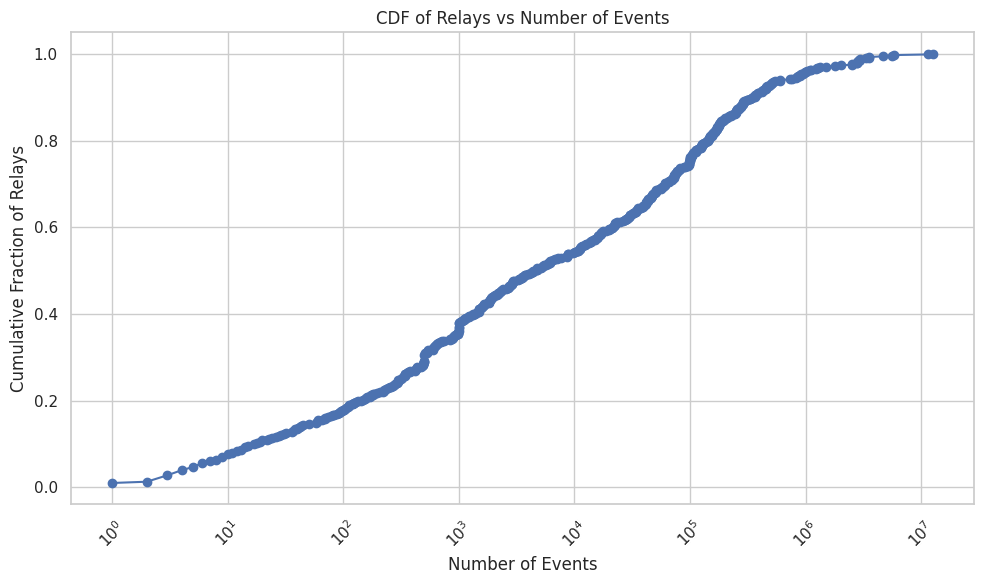

In [19]:
# plot cdf fraction of relays vs number of events
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df['event_count'].value_counts().sort_index().cumsum() / df['event_count'].count(), marker='o')
plt.title('CDF of Relays vs Number of Events')
plt.xlabel('Number of Events')
plt.ylabel('Cumulative Fraction of Relays')
plt.xticks(rotation=45)
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
query = "SELECT * FROM relay_metadata"
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
for row in rows:
    print(row)
len(rows)

In [ ]:
query = "SELECT COUNT(*) FROM events WHERE kind = 1"
bigbrotr.execute(query)
rows = bigbrotr.fetchall()
print(f"Number of events in the database: {rows[0][0]}")

In [20]:
bigbrotr.close()